# <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Benchmarking Loss Functions</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

$WCE = -\frac{1}{N} \sum_{i=1}^{N} \left( \alpha y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right)$

$FCE = -\frac{1}{N} \sum_{i=1}^{N} \left( (1 - p_i)^\gamma \cdot y_i \log(p_i) + (1 - y_i) \cdot p_i^\gamma \log(1 - p_i) \right)$

$NCE = \frac{-\frac{1}{N} \sum_{i=1}^{n} \left( y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right)}{-(p \log(p) + (1 - p) \log(1 - p))}$

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from scipy.special import expit as sigmoid, logit
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["font.family"] = "Virgil GS"

In [3]:
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

In [4]:
dataset['income_binned'] = pd.qcut(dataset['monthly_income'], q=10, duplicates='drop', labels=False)
dataset['inquiries_count'] = pd.qcut(dataset['num_inq_last_6m'], q=10, duplicates='drop', labels=False)

In [5]:
features = [
    'external_risk_estimate',
    'revolving_utilization_of_unsecured_lines',
    'account_never_delinq_percent',
    'net_fraction_revolving_burden',
    'num_total_cc_accounts',
    'average_months_in_file'
    ]

cat_features = ['income_binned', 'inquiries_count']

target = 'is_bad'

In [42]:
X = dataset[features + [target]].copy()
y = X.pop("is_bad")
X.replace([-9, -8, -7], 0, inplace=True)

ix_train, ix_test = train_test_split(X.index, test_size=0.3, random_state=62)

In [43]:
lr_model = LogisticRegression()
lr_model.fit(X.loc[ix_train], y.loc[ix_train])

pred = lr_model.predict_proba(X.loc[ix_test])[:,1]
auc_score = roc_auc_score(y.loc[ix_test], pred)
print(f"Gini score: {auc_score*2-1:.2%}")

Gini score: 80.48%


In [44]:
X_trn, y_trn = X.loc[ix_train].to_numpy(), y.loc[ix_train].to_numpy()
X_tst, y_tst = X.loc[ix_test].to_numpy(), y.loc[ix_test].to_numpy()

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">WOE Logistic regression</span>
<span style="font-family: Virgil GS, sans-serif; color:navyblue">An idea would be randomly select features and to estimate a WOE score per iteration and combine logits from each one to estimate a final logistic regression with all WOEs. </span>

In [9]:
from optbinning import BinningProcess

In [10]:
# make WOE binning
binning_process = BinningProcess(
    list(X.columns),
    categorical_variables=cat_features
    )

binning_process.fit(X_trn, y_trn)
X_trn_woe, X_tst_woe = binning_process.transform(X_trn), binning_process.transform(X_tst)

In [172]:
import numpy as np
from typing import List
from scipy.optimize import minimize


class LogisticRegressionCustomLoss:
    
    """
    Custom implementation of logistic regression using first-order approximation with gradient descent.
    
    This class allows you to perform logistic regression with various loss functions, including:
    1. Cross-Entropy ("ce"): Standard logistic regression.
    2. Weighted Cross-Entropy ("weighted_ce"): Adds class weights to balance the loss.
    3. Focal Cross-Entropy ("focal_ce"): Introduces focal loss to focus on hard-to-classify examples.
    4. Normalized Cross-Entropy ("normalized_ce"): Normalizes the loss based on background click-through rate.
    
    Parameters:
    - learning_rate (float): The learning rate for gradient descent (default: 0.001).
    - n_iterations (int): The number of iterations for training (default: 100).
    - regularization (str): The type of regularization, either "l1" or "l2" (default: None).
    - reg_param (float): The regularization parameter (default: 0.5).
    - use_bias (bool): Whether to fit a bias term (default: False).
    - objective (str): The choice of loss function ("ce," "weighted_ce," "focal_ce," or "normalized_ce").
    - alpha (float): The weighting factor for positive class samples in "weighted_ce" (default: 1.0).
    - gamma (float): The focusing parameter for "focal_ce" (default: 0.0).
    - bias_init (float): initialization parameter for bias (default: 0.0).
    
    Sources:
    [1] 2014. Xinran He, Stuart Bowers, Joaquin Quiñonero Candela, Junfeng Pan, Ou Jin, Tianbing Xu, Bo Liu, Tao Xu, Yanxin Shi, Antoine Atallah, and Ralf Herbrich. 
        Practical Lessons from Predicting Clicks on Ads at Facebook. Proceedings of 20th ACM SIGKDD Conference on Knowledge Discovery and Data Mining - ADKDD'14.
    [2] 2017. Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He, and Piotr Dollár. 2017. Focal Loss for Dense Object Detection.
    [3] 2019. Logistic Regression From Scratch. Data Science, Machine Learning, Deep Learning. Alpha-quantum.com.
    [4] 2020. Chen Wang, Chengyuan Deng, and Shuzhen Wang. Imbalance-XGBoost: Leveraging Weighted and Focal Losses for Binary Label-Imbalanced Classification with XGBoost.

    """
    
    def __init__(
        self, learning_rate: float = 0.001, n_iterations: int = 100, regularization: str = None, 
        reg_param: float = 0.5, use_bias: bool = False, objective: str = 'ce', alpha: float = 1.0, 
        gamma: float = 0.0, weights_init: np.ndarray = None, bias_init: float = 0.0):
        
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.reg_param = reg_param
        self.use_bias = use_bias
        self.objective = objective
        self.alpha = alpha
        self.gamma = gamma
        self.weights_init = weights_init
        self.bias_init = bias_init
        self.calibration_scalar = 0.0

    def _initialize_weights(self, n_features: int):
        # Initialize weights
        if self.weights_init is None:
            self.weights = np.zeros(n_features)
        elif self.weights_init.shape[0] != n_features:
            raise ValueError("The length of weights_init must match the number of input features.")
        else:
            self.weights = self.weights_init
        # Initialize bias
        self.bias = self.bias_init if self.use_bias else None
       
    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))

    def _add_regularization(self, gradient: np.ndarray) -> np.ndarray:
        if self.regularization == 'l1':
            gradient -= self.reg_param * np.sign(self.weights)
        elif self.regularization == 'l2':
            gradient -= 2 * self.reg_param * self.weights
        return gradient

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LogisticRegressionCustomLoss':
                    
        if self.use_bias:
            ones = np.ones((X.shape[0], 1))
            bias_vector = self.bias_init * np.ones((X.shape[0], 1))
            X = np.column_stack((X, bias_vector))
        else:
            ones = np.ones((X.shape[0], 1))
            X = np.column_stack((X, ones))

        n_samples, n_features = X.shape
        self._initialize_weights(n_features)

        for _ in range(self.n_iterations):
            
            y_logit = np.dot(X, self.weights)
            y_pred = self._sigmoid(y_logit)
        
            if self.objective == 'ce':
                gradient = -np.dot(X.T, (y - y_pred)) / n_samples
            elif self.objective == 'weighted_ce':
                weights = np.where(y == 1, self.alpha, 1)
                gradient = -np.dot(X.T, weights * (y - y_pred)) / n_samples
            elif self.objective == 'focal_ce':
                p_t = np.where(y == 1, y_pred, 1 - y_pred)
                gradient = -np.dot(X.T, (1 - p_t) ** self.gamma * (y - y_pred)) / n_samples
            elif self.objective == 'normalized_ce':
                background_ctr = np.mean(y)
                weights_ctr = np.where(y == 1, np.log(background_ctr), np.log(1-background_ctr))
                y_logit_ctr = np.where(y == 1, background_ctr * weights_ctr, (1-background_ctr) * weights_ctr)
                y_pred_ctr = self._sigmoid(y_logit_ctr)
                gradient = -np.dot(X.T, (y - (y_pred/y_pred_ctr))) / n_samples
            else:
                raise ValueError("Invalid objective parameter")

            if self.regularization:
                gradient = self._add_regularization(gradient)
                
            self.weights -= self.learning_rate * gradient
            
        if self.use_bias:
            self.bias = self.weights[-1]

        return self

    # TODOs: add decision rule (next sklearn release)
    def predict(self, X: np.ndarray) -> List[int]:
        linear_model = np.dot(X, self.weights)
        y_pred = self._sigmoid(linear_model)
        return [1 if p >= 0.5 else 0 for p in y_pred]

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.use_bias:
            y_logit = np.dot(X, self.weights[:-1])
            y_logit += self.weights[-1]
        else:
            y_logit = np.dot(X, self.weights[:-1])
        return self._sigmoid(y_logit)
    
    def calibrate(self, X: np.ndarray, calibration_target: float):
        if not self.use_bias:
            raise ValueError("Calibration requires fitting a bias term.")
        
        if self.objective not in ['ce', 'weighted_ce']:
            raise ValueError("Calibration is supported for CE and weighted CE objectives only.")
        
        if not hasattr(self, 'weights'):
            raise ValueError("Model must be fitted before calibration.")
        
       # Calibration weights
        a, b = 0.0, 1.0
        cal_tar = calibration_target

        y_logit = logit(self.predict_proba(X))
        
        def to_minimize(T, A, B, scores, N, target):
            return (1 / N * sum(1 / (1 + np.exp(-(T + A + B * scores)))) - target) ** 2

        res = minimize(
            to_minimize,
            x0=1,
            args=(a, b, y_logit, len(y_logit), cal_tar),
            method='Nelder-Mead',
            options={'xtol': 1e-10, 'disp': False}
        )

        self.calibration_scalar = res.x[0]  # Update calibration_scalar
        
        calibrated_scores = y_logit + self.calibration_scalar
        calibrated_probabilities = self._sigmoid(calibrated_scores)

        return calibrated_probabilities

In [179]:
n_iterations = 100
use_bias_param = True

lr_cl = LogisticRegressionCustomLoss(
    n_iterations=n_iterations, 
    regularization='l1',
    reg_param=0.001,
    use_bias=use_bias_param,
    objective='ce',
    alpha=0.5,
    gamma=2.0,
    bias_init=0.25
)
lr_cl.fit(X_trn_woe, y_trn)

if use_bias_param:
    print(lr_cl.weights[-1], lr_cl.weights[:-1])
else:
    print(lr_cl.weights)

auc_score = roc_auc_score(y_tst, lr_cl.predict_proba(X_tst_woe))
print(f"Gini score: {auc_score*2-1:.2%}")

-0.00974653195235143 [-0.0221075  -0.02814685 -0.05796804 -0.01268557 -0.00127133 -0.00638226
 -0.00217598 -0.0024186 ]
Gini score: 86.29%


In [180]:
# calibrate probabilities to a 5% level
lr_cl.calibrate(X_tst_woe, 0.05).mean()

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_95654/2563993954.py:153: OptimizeWarning: Unknown solver options: xtol
  res = minimize(


0.049998910216315647

In [181]:
sigmoid(np.multiply(
    X_tst_woe, lr_cl.weights[:-1]).sum(axis=1) + lr_cl.bias + lr_cl.calibration_scalar).mean(), \
lr_cl.predict_proba(X_tst_woe).mean()

(0.049998910216315647, 0.4754565534733926)

### Loss functions and performance

In [397]:
n_iterations = 50000
use_bias_param = True

base_params = {
    "n_iterations": n_iterations, 
    "regularization": 'l2',
    "reg_param": 1e-2,
    "use_bias": use_bias_param,
    "alpha": 0.75,
    "gamma": 2.0,
}

lr_model_ce = LogisticRegressionCustomLoss(**base_params, objective='ce')
lr_model_weighted_ce = LogisticRegressionCustomLoss(**base_params, objective='weighted_ce')
lr_model_focal_ce = LogisticRegressionCustomLoss(**base_params, objective='focal_ce')
lr_model_normalized_ce = LogisticRegressionCustomLoss(**base_params, objective='normalized_ce')

clf_list = [
    (lr_model_ce, "Log Loss"), 
    (lr_model_weighted_ce, "Weighted Log Loss"),
    (lr_model_focal_ce, "Focal Log Loss"),
    (lr_model_normalized_ce, "Normalized Log Loss"),
    ]

Name: Log Loss, Gini: 75.56%
Name: Weighted Log Loss, Gini: 75.91%
Name: Focal Log Loss, Gini: 75.65%
Name: Normalized Log Loss, Gini: 77.86%


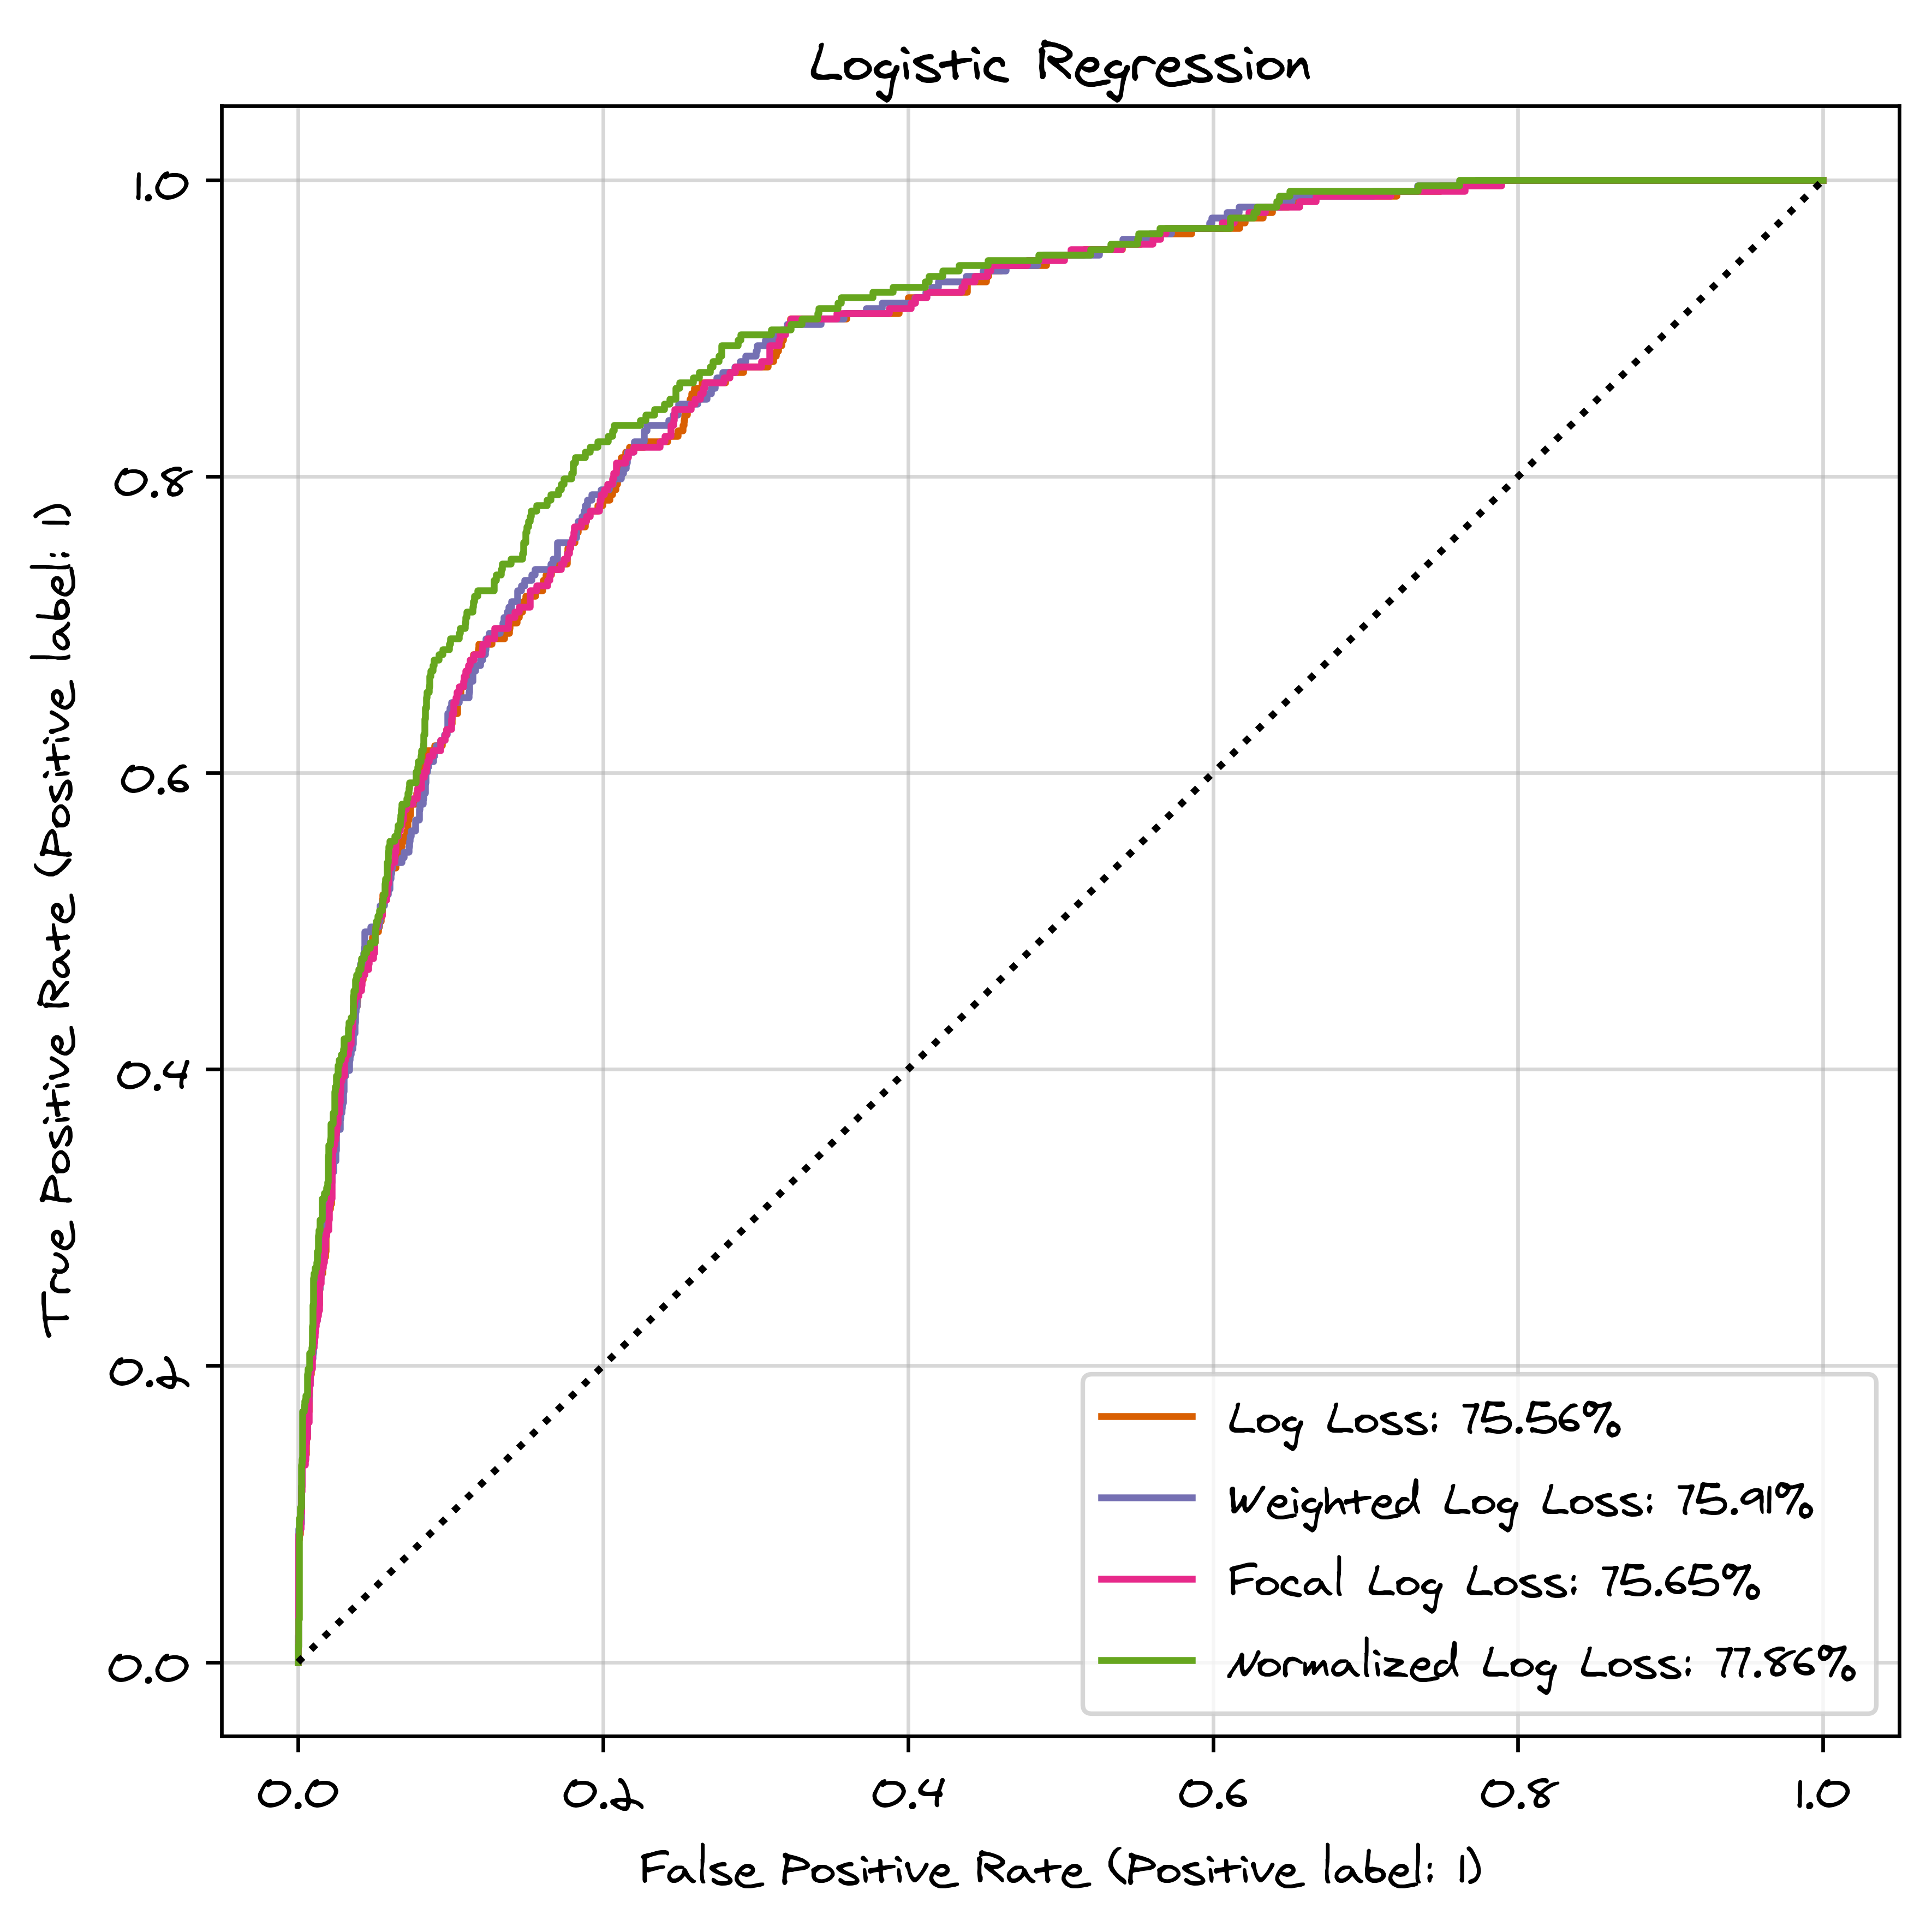

In [403]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6, 6), dpi=600)
ax_roc_auc_curve = plt.axes()
colors = plt.colormaps.get_cmap("Dark2")

roc_auc_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_trn, y_trn)
    y_pred = clf.predict_proba(X_tst)
    gini_score = roc_auc_score(y_tst, y_pred) * 2 - 1
    print(f"Name: {name}, Gini: {gini_score:.2%}")
    
    roc_auc_display = RocCurveDisplay.from_predictions(
        y_tst, y_pred, ax=ax_roc_auc_curve, label=f"{name}: {gini_score:.2%}", color=colors(i + 1)
    )
    roc_auc_displays[name] = roc_auc_display

ax_roc_auc_curve.set_title('Logistic Regression')
ax_roc_auc_curve.grid(alpha=0.5)
ax_roc_auc_curve.plot([0, 1], [0, 1], "k:")
plt.tight_layout()
plt.savefig("/Users/deburky/Documents/content-to-publish/Loss-Functions/png/logistic_regression.png", dpi=600)

### Tuning
Here (focal loss) we "amplify" gradients with a zooming parameter of observations with large log loss. Balancing parameter `alpha` is not used in this implementation.

In [142]:
import itertools
from sklearn.metrics import RocCurveDisplay

gammas = [0.0, 0.5, 1.0, 1.5, 2.0, 3.0]

n_iterations = 50000
use_bias_param = True

base_params = {
    "n_iterations": n_iterations, 
    "regularization": "l2",
    "reg_param": 0.01,
    "use_bias": use_bias_param,
}

lr_model_focal_ce = LogisticRegressionCustomLoss(**base_params, objective='focal_ce')
clf_list = [(lr_model_focal_ce, "Focal Log Loss")]

for (clf, name), gamma in itertools.product(clf_list, gammas):

    base_params_with_gamma = base_params.copy()
    base_params_with_gamma['gamma'] = gamma

    lr_model = LogisticRegressionCustomLoss(objective=clf.objective, **base_params_with_gamma)
    lr_model.fit(X_trn, y_trn)
    y_pred = lr_model.predict_proba(X_tst)
    gini_score = roc_auc_score(y_tst, y_pred) * 2 - 1
    print(f"Gamma: {gamma}, Gini: {gini_score:.2%}")

Gamma: 0.0, Gini: 75.56%
Gamma: 0.5, Gini: 75.50%
Gamma: 1.0, Gini: 75.51%
Gamma: 1.5, Gini: 75.60%
Gamma: 2.0, Gini: 75.65%
Gamma: 3.0, Gini: 75.23%


Here we tune the balancing parameter alpha for weighted cross-entropy. We can see that the optimal value is around 0.75.

In [125]:
import itertools

alphas = [1.0, 0.75, 0.5, 0.25, 0.1]

n_iterations = 50000
use_bias_param = True

base_params = {
    "n_iterations": n_iterations, 
    "regularization": "l2",
    "reg_param": 0.01,
    "use_bias": use_bias_param,
    "bias_init": 0.25
}

lr_model_weighted_ce = LogisticRegressionCustomLoss(**base_params, objective='weighted_ce')
clf_list = [(lr_model_weighted_ce, "Weighted Log Loss")]

for (clf, name), alpha in itertools.product(clf_list, alphas):

    base_params_with_alpha = base_params.copy()
    base_params_with_alpha['alpha'] = alpha

    lr_model = LogisticRegressionCustomLoss(objective=clf.objective, **base_params_with_alpha)
    lr_model.fit(X_trn, y_trn)
    y_pred = lr_model.predict_proba(X_tst)
    gini_score = roc_auc_score(y_tst, y_pred) * 2 - 1
    print(f"Alpha: {alpha}, Gini: {gini_score:.2%}")

Alpha: 0.1, Gini: 71.68%
Alpha: 0.25, Gini: 74.03%
Alpha: 0.5, Gini: 75.82%
Alpha: 0.75, Gini: 75.96%
Alpha: 1.0, Gini: 75.63%


### XGBoost loss functions
[Source](https://datascience.stackexchange.com/questions/74780/how-to-implement-custom-loss-function-that-has-more-parameters-with-xgbclassifie)

In [390]:
import xgboost as xgb

In [391]:
# Imbalanced XGBoost loss function
def get_weighted_log_loss(alpha=0.25):
    def weighted_loss_grad_hess(y_true, y_pred):
        weights = np.where(y_true == 1.0, alpha, 1)
        preds = 1.0 / (1.0 + np.exp(-y_pred))
        grad = preds - y_true
        hess = preds * (1.0 - preds)
        return grad * weights, hess * weights
    return weighted_loss_grad_hess

# Imbalanced XGBoost focal loss function
def get_focal_log_loss(gamma=2.0):
    def focal_loss_grad_hess(y_true, y_pred):
        preds = 1.0 / (1.0 + np.exp(-y_pred))
        p_t = np.where(y_true == 1, preds, 1 - preds)
        grad = (preds - y_true) * (1 - p_t) ** gamma
        hess = preds * (1.0 - preds) ** gamma
        return grad, hess
    return focal_loss_grad_hess

# Normalized cross-entropy loss function
def get_normalized_log_loss(background_ctr):
    def normalized_loss_grad_hess(y_true, y_pred):
        preds = 1.0 / (1.0 + np.exp(-y_pred))
        weights_ctr = np.where(y_true == 1, np.log(background_ctr), np.log(1 - background_ctr))
        y_logit_ctr = np.where(y_true == 1, background_ctr * weights_ctr, (1 - background_ctr) * weights_ctr)
        y_pred_ctr = 1 / (1 + np.exp(-y_logit_ctr))
        grad = (preds / y_pred_ctr) - y_true
        hess = preds/y_pred_ctr * (1 - preds) / (1 - y_pred_ctr)
        return grad, hess
    return normalized_loss_grad_hess

In [405]:
xgb_model_ce = xgb.XGBClassifier()
xgb_model_weighted_ce = xgb.XGBClassifier(
    objective=get_weighted_log_loss(alpha=0.10)
    )
xgb_model_focal_ce = xgb.XGBClassifier(
    objective=get_focal_log_loss(gamma=10.0)
    )
xgb_model_normalized_ce = xgb.XGBClassifier(
    objective=get_normalized_log_loss(background_ctr=np.mean(y_trn))
    )

clf_list = [
    (xgb_model_ce, "Log Loss"), 
    (xgb_model_weighted_ce, "Weighted Log Loss"),
    (xgb_model_focal_ce, "Focal Log Loss"),
    (xgb_model_normalized_ce, "Normalized Log Loss"),
    ]

for clf, name in clf_list:
    clf.fit(X_trn, y_trn)
    y_pred = clf.predict_proba(X_tst)[:, 1]
    gini_score = roc_auc_score(y_tst, y_pred) * 2 - 1
    print(f"Name: {name}, Gini: {gini_score:.2%}")

Name: Log Loss, Gini: 87.96%
Name: Weighted Log Loss, Gini: 88.61%
Name: Focal Log Loss, Gini: 88.96%
Name: Normalized Log Loss, Gini: 89.11%


Name: Log Loss, Gini: 87.96%
Name: Weighted Log Loss, Gini: 88.61%
Name: Focal Log Loss, Gini: 88.96%
Name: Normalized Log Loss, Gini: 89.11%


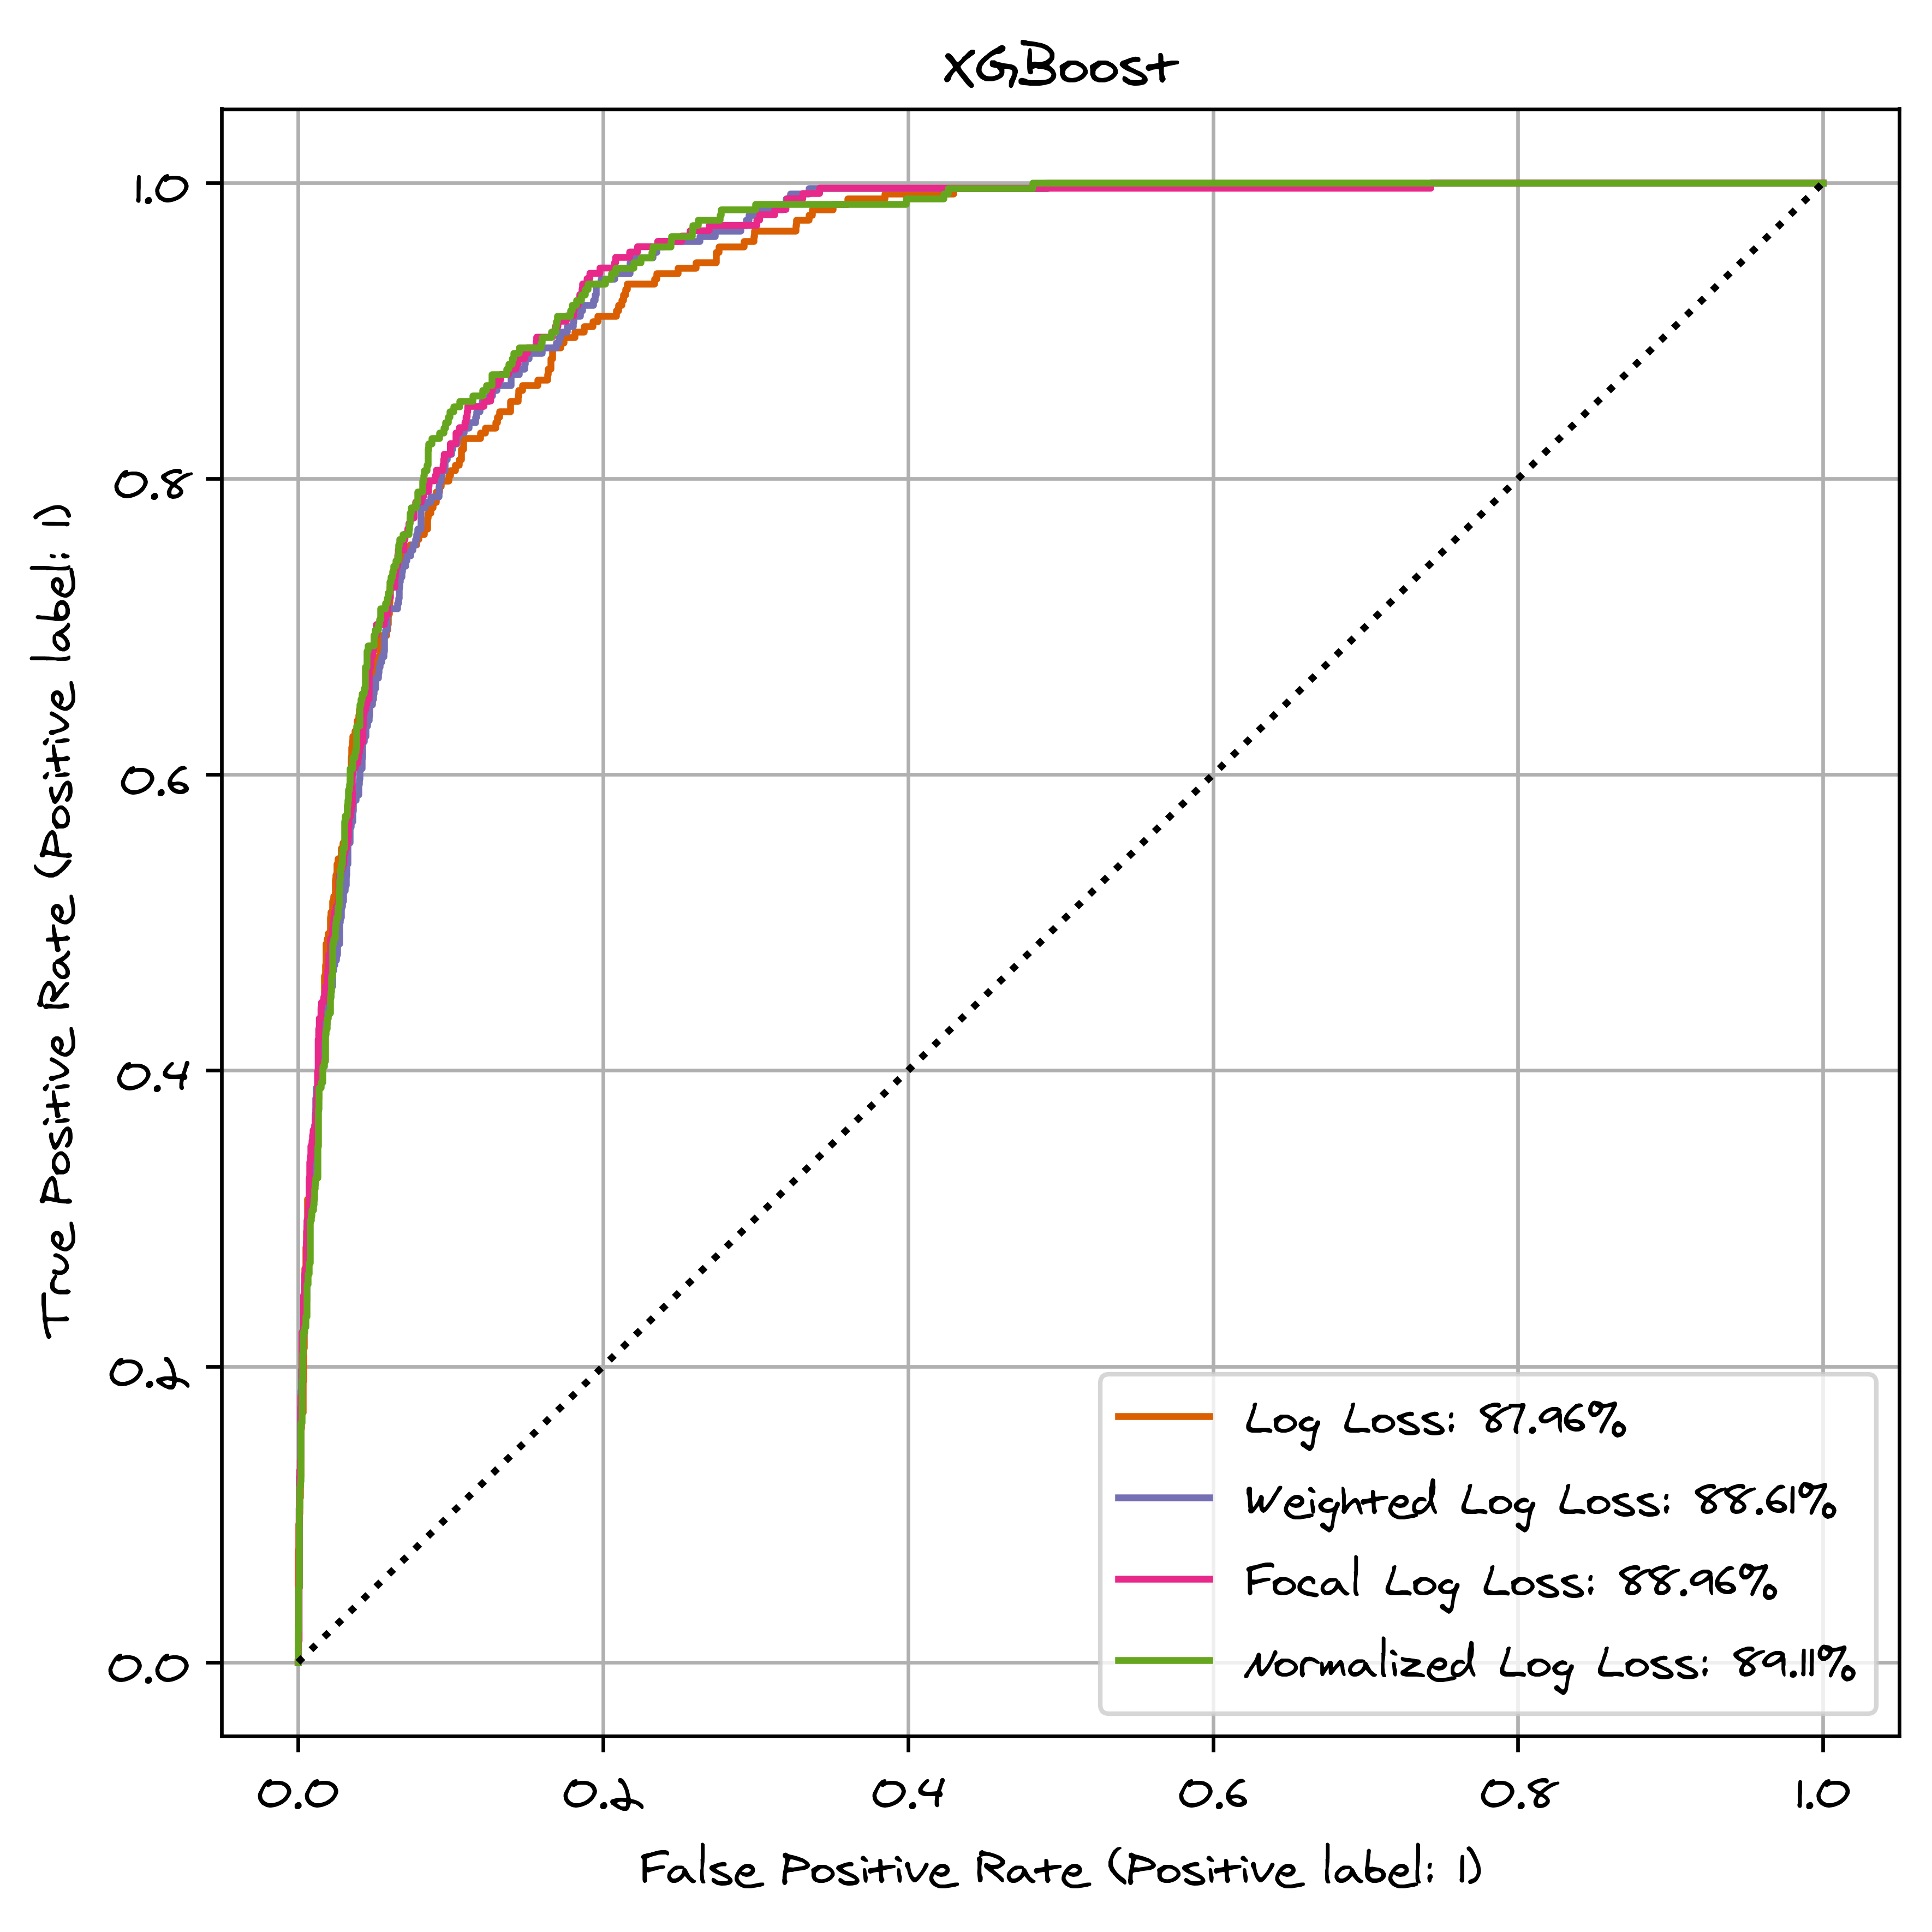

In [406]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6, 6), dpi=600)
ax_roc_auc_curve = plt.axes()
colors = plt.colormaps.get_cmap("Dark2")

roc_auc_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_trn, y_trn)
    y_pred = clf.predict_proba(X_tst)[:,1]
    gini_score = roc_auc_score(y_tst, y_pred) * 2 - 1
    print(f"Name: {name}, Gini: {gini_score:.2%}")
    
    roc_auc_display = RocCurveDisplay.from_predictions(
        y_tst, y_pred, ax=ax_roc_auc_curve, label=f"{name}: {gini_score:.2%}", color=colors(i + 1)
    )
    roc_auc_displays[name] = roc_auc_display
ax_roc_auc_curve.set_title('XGBoost')
ax_roc_auc_curve.grid()
ax_roc_auc_curve.plot([0, 1], [0, 1], "k:")
plt.tight_layout()
plt.savefig("/Users/deburky/Documents/content-to-publish/Loss-Functions/png/xgboost.png", dpi=600)

### Tuning for Normalized Log Loss

CTR     0.990000
Gini    0.893334
dtype: float64


<Axes: xlabel='CTR'>

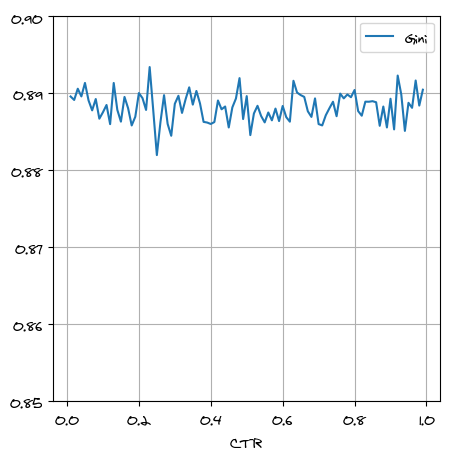

In [368]:
# Tuning normalized Cross-entropy
ctr_history = {'CTR': [], 'Gini': []}
background_ctrs = np.linspace(0.01, 0.99, 99)

for ctr in background_ctrs:
    model = xgb.XGBClassifier(
        objective=get_normalized_log_loss(background_ctr=ctr)
        )

    model.fit(X_trn, y_trn)
    
    ctr_history['CTR'].append(ctr)
    ctr_history['Gini'].append(roc_auc_score(y_tst, model.predict_proba(X_tst)[:, 1]) * 2 - 1)
    
print(pd.DataFrame(ctr_history).max())
pd.DataFrame(ctr_history).plot(x='CTR', y='Gini', figsize=(5, 5), ylim=(0.85, 0.9), grid=True)